Using specs from a MIM-104 Patriot PAC1 and a russian SU-27 at cruise speed at 10,000m  
Missile at origin, plane traveling in y direction offset by x = 10000 m , z = 10000m 


In [208]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
np.set_printoptions(precision = 3, suppress = True)


dt = .1    #10hz

#initial uncertainty in pos, same for any dimension
pos_var0 = 500 #m
max_plane_vel = 1553*1609.34/3600     #m/s
plane_vel = 840*1609.34/3600          #m/s

# 99% sure the plane is is within the max speed
# abs(max_speed) is within 3 std 
vel_var0 = (max_plane_vel/3)**2
# 99% sure accel due to windspeed is within 20 m/s^2
accel_var = (20/3)**2   # (m/s^2)^2
#noise in sensor
sensor_var = 25  #m^2

Matrices For Prediction Steps

State Transition Function:
$$
A = \begin{bmatrix} 1 & 0 & 0 & dt & 0 & 0 \\ 0 & 1 & 0 & 0 & dt & 0 \\ 
                    0 & 0 & 1 & 0 & 0 & dt \\ 0 & 0 & 0 & 1 & 0 & 0  \\
                    0 & 0 & 0 & 0 & 1 & 0  \\ 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix}
$$
Process Covariance Matrix  
$$
P = \begin{bmatrix} \sigma_x^2 & 0 & 0 & 0 & 0 & 0 \\ 0 & \sigma_y^2 & 0 & 0 & 0 & 0 \\ 
                    0 & 0 & \sigma_z^2 & 0 & 0 & 0 \\ 0 & 0 & 0 & \sigma_{v_x}^2 & 0 & 0  \\
                    0 & 0 & 0 & 0 & \sigma_{v_y}^2 & 0  \\ 0 & 0 & 0 & 0 & 0 & \sigma_{v_z}^2 \end{bmatrix}
$$
Process Noise  
$$ 
Q = \begin{bmatrix} .25(dt)^4 & 0 & 0 & .5(dt)^3 & 0 & 0 \\ 0 & .25(dt)^4 & 0 & 0 & .5(dt)^3 & 0 \\ 
                    0 & 0 & .25(dt)^4 & 0 & 0 & .5(dt)^3 \\ .5(dt)^3 & 0 & 0 & (dt)^2 & 0 & 0  \\
                    0 & .5(dt)^3 & 0 & 0 & (dt)^2 & 0  \\ 0 & 0 & .5(dt)^3 & 0 & 0 & (dt)^2 \end{bmatrix}
$$ 

Matrices for Update Step  

Sensor Covariance Matrix
$$
R = \begin{bmatrix} \sigma_{sens_x}^2 & 0 & 0 \\ 0 & \sigma_{sens_y}^2 & 0 \\ 0 & 0 & \sigma_{sens_z}^2 \end{bmatrix}
$$

Measurement Function
$$
H = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 \\ 
                    0 & 0 & 1 & 0 & 0 & 0 \end{bmatrix}
$$

In [209]:

#setting up matrices for prediction and update steps
#State Transition Function
A = np.array([[1, 0, 0, dt, 0 ,0],[0, 1, 0, 0, dt,0],[0, 0, 1, 0, 0,dt],
              [0, 0, 0, 1, 0 ,0 ], [0, 0, 0, 0, 1 ,0],[0, 0, 0, 0, 0,1]])
#State Covariance
#Assuming I have no knowledge of covariance between pos and vel
P = np.array([[pos_var0, 0,0,0,0,0],[0, pos_var0,0,0,0,0],[0, 0,pos_var0,0,0,0],
             [0, 0,0,vel_var0,0,0],[0, 0,0,0,vel_var0,0],[0, 0,0,0,0,vel_var0],])

#Process Covariance
#This uses a discrete noise model with constant velocity
Q = np.array([[.25*dt**4, 0, 0, .5*dt**3, 0 ,0],
              [0, .25*dt**4, 0, 0, .5*dt**3,0],
              [0, 0, .25*dt**4, 0, 0,.5*dt**3],
              [.5*dt**3, 0, 0, dt**2, 0 ,0],
              [0, .5*dt**3, 0, 0, dt**2,0],
              [0, 0, .5*dt**3, 0, 0,dt**2]])*accel_var

#Sensor Noise Covariance
#variance in measured xpos, ypos, zpos
R = np.eye(3)*sensor_var  #wiki says about 25 meters variance?   
# Measurement Function, getting measurements in meters already
H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])
I = np.eye(6)

In [ ]:
def update_accel(target,missile,N):    
    R = (target[0:3,0] - missile[0:3,0]).reshape((3,1))
    Vr = (target[3:,0] - missile[3:,0]).reshape((3,1))
    Omega = np.cross(R,Vr,axis = 0)/(R.T@R)
    a = N*np.cross(Vr,Omega,axis=0)
    return a

In [210]:
# define kalman filter function to be used at each iteration
def kfilter(x, A, Q, P, H, R, I, z):
    # PREDICT STEP
    #predict the state and the process covariance matrix
    
    x_pred = A @ x
    P_pred = A @ P @ A.T + Q
    
    # UPDATE STEP
    #calcultate kalman gain and update the process covariance matrix
    
    S = (H @ P_pred @ H.T) + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    #calculate residual
    y = z - (H @ x_pred)
    # update state using Kalman gain and residual
    x = x_pred + (K @ y)
    #update Process Covar matrix
    P = (I - K @ H) @ P_pred
    return x, P

In [211]:
# initial true state of plane
plane_true_state = np.array([[10000, 0, 10000, 0, plane_vel, 0]]).T

# define function to update true position of plane
def plane_update_true(A, plane_true):
    return A @ plane_true
# simulate measurement by adding noise to true position, leave vel untouched
def measure_pos(plane_true, var): 
    noise = np.append(np.random.randn(3)*var,[0 ,0,0]).reshape(6,1)
    return noise + plane_true

In [212]:
# Take 2 measurements of first 2 evolutions and use these as initial
# state estimates


# records will be kept with observations going down rows, table form
# state will remain col vector
plane_true_record = np.zeros((2,6))
plane_measure_record = np.zeros((2,6))

#record 1st entry
plane_true_record[0,None,:] = plane_true_state.T
plane_measure_record[0,None,:] = measure_pos(plane_true_state, sensor_var).T
#next epoch
plane_true_state = plane_update_true(A, plane_true_state)
#record second entries
plane_true_record[1,None,:] = plane_true_state.T
plane_measure_record[1,None,:] = measure_pos(plane_true_state, sensor_var).T

#calculate x0 from latest position measure and vel from latest 2 pos measurement
est_pos = plane_measure_record[1,None,0:3]
est_vel = (plane_measure_record[1,None,0:3]-plane_measure_record[0,None,0:3])/dt
#initial estimate
x0 = np.append(est_pos,est_vel).reshape(6,1) #col vector form for Kalman Filter

In [213]:
# Enter kalman filter loop
# true state evolves --> measurement taken --> filter gives estimate -->
# record values --> repeat
N =40
x = x0
x_states = np.empty((0,6))
Ps       = np.empty((0,6))
zs       = np.empty((0,3))
for i in range(N):
    plane_true_state = plane_update_true(A,plane_true_state)
    z = measure_pos(plane_true_state,sensor_var)[0:3]
    x, P = kfilter(x, A, Q, P, H, R, I, z)
 
    #records for plotting
    x_states = np.vstack((x_states,x.T))
    plane_true_record =  np.vstack((plane_true_record,plane_true_state.T))
    zs = np.vstack((zs, z.T))
    #only interested in keeping the variances
    Ps = np.vstack((Ps,np.diag(P)))

Text(0, 0.5, 'X position (m)')

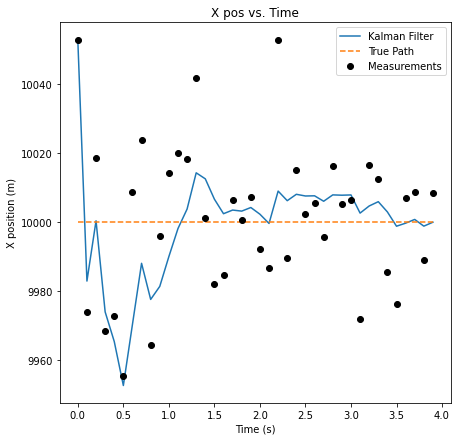

In [215]:
timevec = np.arange(N)*dt
plt.plot(timevec,x_states[:,0],timevec,plane_true_record[2:,0],
         '--',timevec,zs[:,0],'ko')
plt.legend(['Kalman Filter','True Path','Measurements'])
plt.title("X pos vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("X position (m)")

Text(0, 0.5, 'Y position (m)')

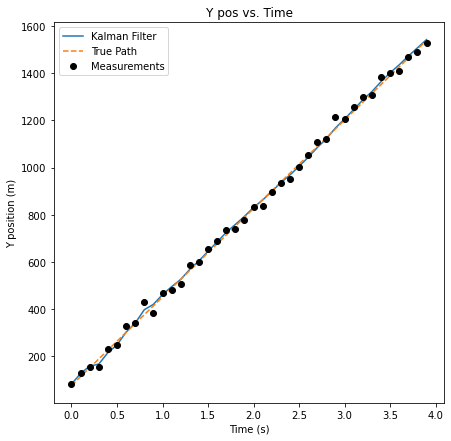

In [216]:
plt.plot(timevec,x_states[:,1],timevec,plane_true_record[2:,1],
         '--',timevec,zs[:,1],'ko')
plt.legend(['Kalman Filter','True Path','Measurements'])
plt.title("Y pos vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("Y position (m)")

Text(0, 0.5, 'Z position (m)')

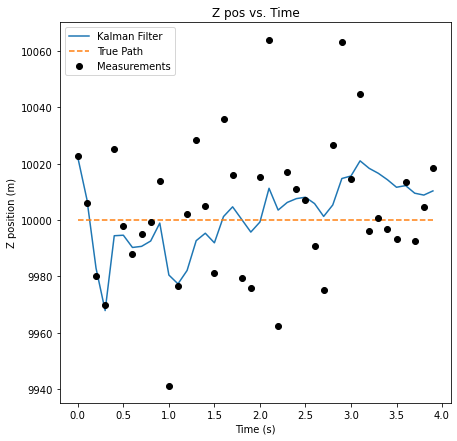

In [218]:
plt.plot(timevec,x_states[:,2],timevec,plane_true_record[2:,2],
         '--',timevec,zs[:,2],'ko')
plt.legend(['Kalman Filter','True Path','Measurements'])
plt.title("Z pos vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("Z position (m)")

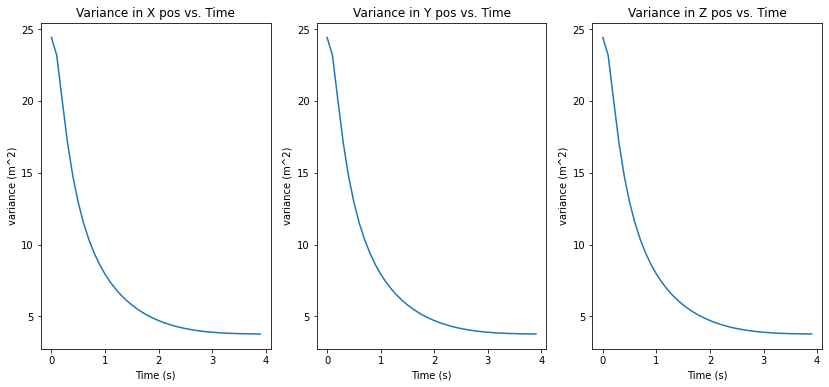

In [219]:
# Process Variances across time
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(131)
plt.xlabel("Time (s)")
plt.ylabel("variance (m^2)")
plt.title("Variance in X pos vs. Time")
ax1.plot(timevec, Ps[:,0])

ax2 = fig.add_subplot(132)
plt.xlabel("Time (s)")
plt.ylabel("variance (m^2)")
plt.title("Variance in Y pos vs. Time")
ax2.plot(timevec, Ps[:,1])

ax3 = fig.add_subplot(133)
plt.xlabel("Time (s)")
plt.ylabel("variance (m^2)")
plt.title("Variance in Z pos vs. Time")
ax3.plot(timevec, Ps[:,2])
